# Derivative Matrix - A Trick with Grassmann Numbers

This notebook is linked to the following
[blog post](https://harpaz.wordpress.com/2024/11/18/derivative-matrix-part-2-a-trick/)
, and is a follow up to 
[this notebook](https://github.com/dor2727/blog_content/blob/main/derivative_matrix.ipynb)
and to
[this blog post](https://harpaz.wordpress.com/2024/11/18/derivative-matrix/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *

from IPython.display import display

init_printing(use_unicode=True)

# Implementing Grassmann Numbers in sympy

Based on:
https://stackoverflow.com/questions/48709140/is-it-possible-to-construct-symbols-in-sympy-that-anticommute

## Implementing the class

In [2]:
class Grassmann(Symbol):
    def __new__(cls,*args,**kwargs):
        return super().__new__(cls,*args,**kwargs,commutative=False)

    def __mul__(self,other):
        if isinstance(other,Grassmann):
            if other==self:
                return S.Zero
            elif other.name<self.name:
                return -Symbol.__mul__(other,self)

        return super().__mul__(other)

    def __pow__(self,exponent):
        if exponent>=2:
            return S.Zero
        else:
            return super().__pow__(exponent)

### Small sanity check - multiplication

In [3]:
a, b = symbols("a b")
theta_1 = Grassmann("theta_1")
a + b * theta_1

In [4]:
expand((a + b * theta_1) ** 2)

### Small sanity check - in matrices

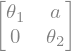

In [5]:
theta_2 = Grassmann("theta_2")

M = Matrix([[theta_1, a],[0,theta_2]])
M

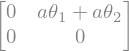

In [6]:
M@M

## Imaginary Part

In [7]:
term = (M@M)[0,1]
term

In [8]:
# for IMaginary part of Grassmann number
def ImG(term, grassmann):
    return diff(term, grassmann)

In [9]:
ImG(term, theta_1)

# Blog Idea 4

## 3x3

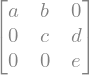

In [10]:
a,b,c,d,e = symbols("a b c d e")
M = Matrix([[a,b,0],
            [0,c,d],
            [0,0,e]])
M

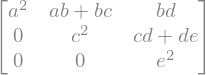

In [11]:
M2 = M@M
M2

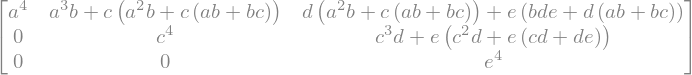

In [12]:
M4 = M@M@M@M
M4

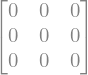

In [13]:
theta = Grassmann("theta")
M4.subs({a: theta, c: theta, e: theta})

## 4x4

We'll use a normal variable here, named $\theta$, so that we'll see where we get $\theta^2$ terms
</br>
Plus, we'll use the values we've already found for $b$,$d$

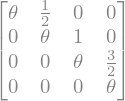

In [14]:
theta = symbols("theta")
half = 1/Integer(2)
M = Matrix([[theta, half,  0,      0     ],
            [0,     theta, 2*half, 0     ],
            [0,     0,     theta,  3*half],
            [0,     0,     0,      theta ]])
M

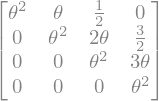

In [15]:
M2 = M@M
M2

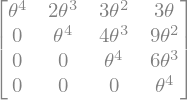

In [16]:
M4 = M@M@M@M
M4

# Blog Idea 5

## Defining the matrix

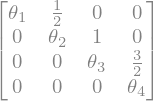

In [17]:
theta_1 = Grassmann("theta_1")
theta_2 = Grassmann("theta_2")
theta_3 = Grassmann("theta_3")
theta_4 = Grassmann("theta_4")
M = Matrix([[theta_1, half,    0,       0      ],
            [0,       theta_2, 2*half,  0      ],
            [0,       0,       theta_3, 3*half ],
            [0,       0,       0,       theta_4]])
M

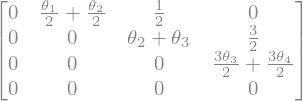

In [18]:
M2 = M@M
M2

## From $M^2$ to $D$

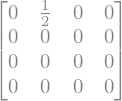

In [19]:
ImG(M2, theta_1)

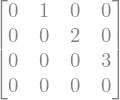

In [20]:
sum(
    (ImG(M2, theta) for theta in [theta_1, theta_2, theta_3, theta_4]),
    zeros(*M.shape)  # initial value
)

## From $M^4$ to $D^2$

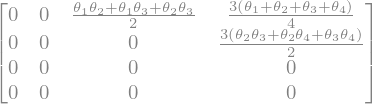

In [21]:
M4 = simplify( M@M@M@M )
M4

In [22]:
import itertools

thetas = [theta_1, theta_2, theta_3, theta_4]
list(itertools.combinations(thetas, 2))

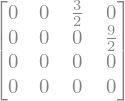

In [23]:
sum(
    (ImG(ImG(M4, t1), t2) for t1,t2 in itertools.combinations(thetas, 2)),
    zeros(*M.shape)  # initial value
)

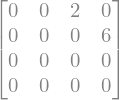

In [24]:
# Should be
Matrix([[0, 0, factorial(2), 0],
        [0, 0, 0, factorial(3)],
        [0, 0, 0, 0],
        [0, 0, 0, 0]])

## From $M^6$ to $D^3$

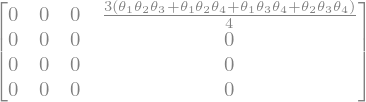

In [25]:
M6 = simplify( M@M@M@M@M@M )
M6

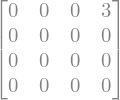

In [26]:
sum(
    (ImG(ImG(ImG(M6, t1), t2), t3) for t1,t2,t3 in itertools.combinations(thetas, 3)),
    zeros(*M.shape)  # initial value
)

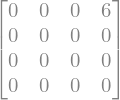

In [27]:
# Should be
Matrix([[0, 0, 0, factorial(3)],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]])

# Generalizing

## Initialize $M_\theta$

In [28]:
def build_M_theta(n):
    M = zeros(n,n)

    thetas = [Grassmann(f"theta_{i}") for i in range(n)]
    
    # build diagonal
    for row in range(n):
        M[row,row] = thetas[row]
    # build off-diagonal
    for row in range(n-1):
        M[row,row+1] = Integer(row+1) / Integer(2)

    return M, thetas

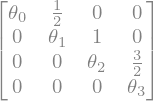

In [29]:
M, thetas = build_M_theta(4)
M

## Take multiple imaginary parts

In [30]:
def multi_ImG(term, *grassmann_numbers):
    for g in grassmann_numbers:
        term = ImG(term, g)
    return term

In [31]:
import itertools

def get_D_n(M, thetas, n):
    if n > M.shape[0]:
        return zeros(*M.shape)

    raw_D = simplify( M**(n*2) )

    return sum(
        (
            multi_ImG(raw_D, *combination)
            for combination in itertools.combinations(thetas, n)
        ),
        zeros(*M.shape)  # initial value
    )

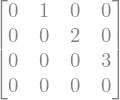

In [32]:
get_D_n(M, thetas, 1)

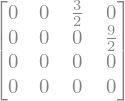

In [33]:
get_D_n(M, thetas, 2)

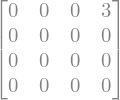

In [34]:
get_D_n(M, thetas, 3)

### Creating $D$

In [35]:
def build_D(n: int) -> Matrix:
    result = zeros(n,n)
    for row in range(n-1):
        result[row, row+1] = Integer(row+1)
    return result

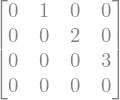

In [36]:
D = build_D(4)
D

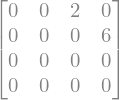

In [37]:
D ** 2

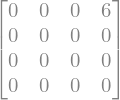

In [38]:
D ** 3

## Larger matrices

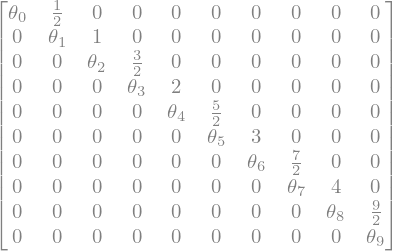

In [39]:
n = 10
M, thetas = build_M_theta(n)
M

### Manually comparing $M^2$ to $D$

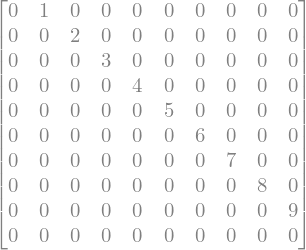

In [40]:
D1 = get_D_n(M, thetas, 1)
D1

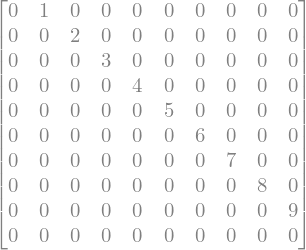

In [41]:
D = build_D(n)
D

In [42]:
def _div(x, y):
    if x == 0 and y == 0:
        return 0
    elif x == 0 or y == 0:
        return nan
    else:
        return x / y

def div(M1, M2):
    return Matrix([[_div(M1[i,j], M2[i,j]) for j in range(M1.shape[0])] for i in range(M1.shape[1])])

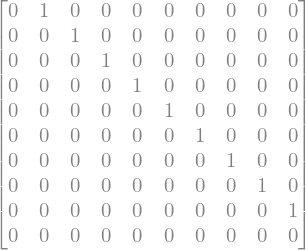

In [43]:
div(D, D1)

### Onto $D^n$

In [44]:
n = 10
M, thetas = build_M_theta(n)
D = build_D(n)

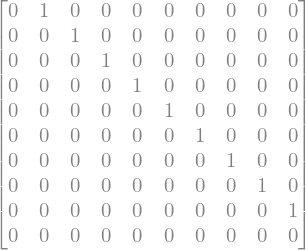

In [45]:
i = 1
div(D**i, get_D_n(M, thetas, i))

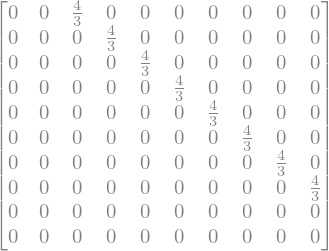

In [46]:
i = 2
div(D**i, get_D_n(M, thetas, i))

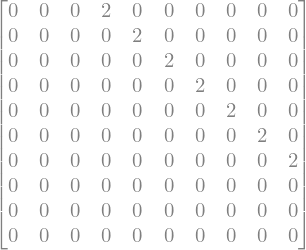

In [47]:
i = 3
div(D**i, get_D_n(M, thetas, i))

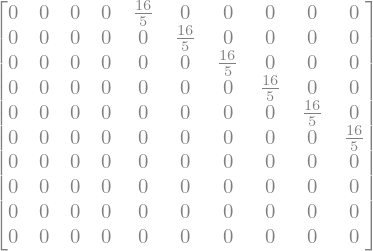

In [48]:
i = 4
div(D**i, get_D_n(M, thetas, i))

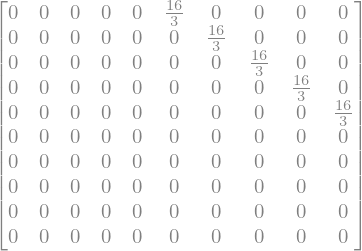

In [49]:
i = 5
div(D**i, get_D_n(M, thetas, i))

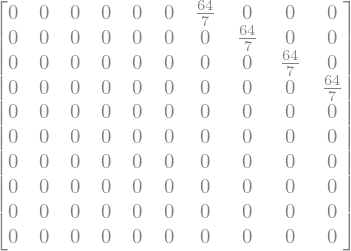

In [50]:
i = 6
div(D**i, get_D_n(M, thetas, i))

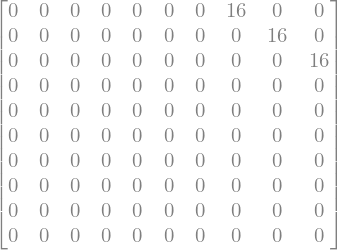

In [51]:
i = 7
div(D**i, get_D_n(M, thetas, i))

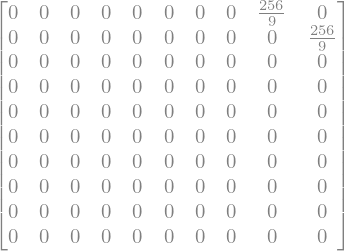

In [52]:
i = 8
div(D**i, get_D_n(M, thetas, i))

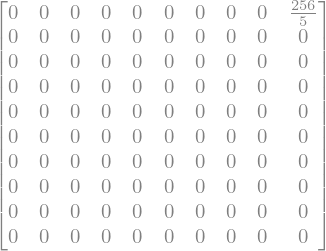

In [53]:
i = 9
div(D**i, get_D_n(M, thetas, i))

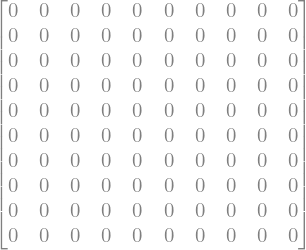

In [54]:
i = 10
div(D**i, get_D_n(M, thetas, i))

# Finalizing

Status:

- `build_M_theta(n)` : working
- `build_D(n)` : working
- `get_D_n(M, thetas, 1)` : needs to add factor
- `div(X,Y)` : working

In [55]:
def get_factor(n):
    return Integer(2)**n / (n+1)

In [56]:
def get_D_n_with_factor(M, thetas, n):
    return get_factor(n) * get_D_n(M, thetas, n)

In [57]:
M, theta = build_M_theta(10)
D = build_D(10)

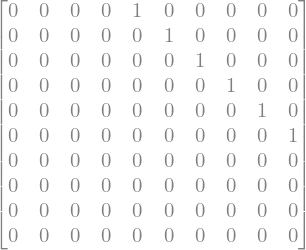

In [58]:
div(D**4, get_D_n_with_factor(M, theta, 4))

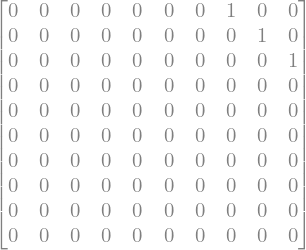

In [59]:
div(D**7, get_D_n_with_factor(M, theta, 7))